## Tractography : deterministic tracking

Tractography is used to combine the information from modeling the distribution of fascicles in every individual voxel (see [Modeling diffusion I](DTI.ipynb) and [Modeling diffusion II](SFM.ipynb)) into information about the trajectory of long-range connections within the white matter between distant cortical and sub-cortical regions.

To do this, the algorithms propagate streamlines through the directions estimated by the models, connecting different voxels. Importantly, these streamlines should not be misinterpreted as direct axonal connections between different regions. The scale of the measurement is such that large bundles. 

Furthermore, these methods are prone to both false alarms and misses. In particular, small close-range connections (e.g. so-called U-fibers that travel between neighboring cortical regions) are not easily detectable at the resolution that is currently measured with this method. Nevertheless, this method does detect many interesting connections. For example, we can detect the location of the optic radiations, which connect the LGN with the primary visual cortex in every individual. 

We start by importing a few of the necessary components. 

In [1]:
import dipy.data as dpd

In [2]:
import os.path as op

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
%matplotlib inline

import dipy.core.gradients as grad
from dipy.data import get_sphere
from dipy.reconst.peaks import peaks_from_model

from dipy.reconst import dti
from dipy.io.trackvis import save_trk
from dipy.tracking.local import LocalTracking

from IPython.display import display, Image

We will examine diffusion data collected with a b-value of 2000 $s/mm^2$. We will use additional information: a pre-defined region of interest (ROI) containing the gray-matter voxels that encompass the primary visual cortex, V1. This is based on measurements of fMRI BOLD responses in the same indivdual, using standard population receptive field mapping methods (following Dumoulin and Wandell, 2008).

Because we want to track streamlines through the white matter, but not through the gray matter, we need to identify those voxels in the volume that contain the white matter. For this purpose, in addition to the diffusion data and ROI, we rely on a segmentation of the tissue into gray and white matter done with [Freesurfer](http://freesurfer.net/). This produces a set of labels, which designates the 'identity' of every voxel in the volume, stored in the 'aparc-reduced.nii.gz' file. For example, voxels that have a '`1`' or a '`2`' in them are in the white matter.

In [3]:
dwi_ni = nib.load(op.join('data', 'SUB1_b2000_1.nii.gz'))
LV1_ni = nib.load(op.join('data', 'SUB1_LV1.nii.gz'))
labels_ni = nib.load(op.join('data', 'SUB1_aparc-reduced.nii.gz'))

data = dwi_ni.get_data()
affine = dwi_ni.get_affine()

LV1_data = LV1_ni.get_data()
labels = labels_ni.get_data()

We create a gradient-table object from the b-values and diffusion-weighting directions:

In [4]:
gtab = grad.gradient_table(op.join('data', 'SUB1_b2000_1.bvals'), op.join('data', 'SUB1_b2000_1.bvecs'))

Masks are generated containing `True` values in the voxels in the white matter/V1 respectively, and `False` values else-where.

In [5]:
white_matter =  (labels == 1) | (labels == 2)
V1 = (LV1_data == 1)

Tracking requires a local model of the orientation distribution function (ODF) every voxel. In this case, we will use the [tensor model](DTM.ipynb) to recover an estimate of the diffusion ODF:

In [6]:
dt_model = dti.TensorModel(gtab)

For the purpose of tracking, we need to identify the peak of the ODF in every voxel. In this case, we perform this peak detection using the `peaks_from_model` function. 

We're going to fit the model each of the voxels that is in the white matter in the following cell, so this might take a little while to run.

In [7]:
sphere = get_sphere()
pnm = peaks_from_model(dt_model, data, sphere,
                       relative_peak_threshold=.5,
                       min_separation_angle=25,
                       mask=white_matter)

Next, we need to create an object that tells the tracking when to stop. This happens when the next step in tracking would have led the streamline out of the predefined part of the brain for which we are interested in tracking. In this case, we generate an object that classifies the tissue based on the white-matter segmentation we used before:

In [8]:
from dipy.tracking.local import ThresholdTissueClassifier
classifier = ThresholdTissueClassifier(white_matter.astype(float), 0.0)

Tracking is initiated in seed points distributed within the ROI. In this case, we seed the tracking in the pre-defined V1 ROI. Before we generate seeds, however, we extend the ROI into the white-matter. This is done by smoothing the boundaries of the ROI with a gaussian blur, and thresholding the blurred image:

In [9]:
V1_extended = ndi.gaussian_filter(V1.astype(float), sigma=0.25).astype(bool)

We distribute plenty of seeds around V1: 8 in every voxel in the ROI, distributed as `[2, 2, 2]`, that is at a sampling rate of 2x2x2 in each voxel, along each dimension (x/y/z).

In [10]:
from dipy.tracking import utils
seeds = utils.seeds_from_mask(V1_extended, density=[2, 2, 2], affine=affine)

Finally, we are ready to perform the tracking itself. Tracking will be based on all the elements that we have defined so far: the ODF peaks (stored in `pnm`), the tissue boundaries (in `classifier`), the seeds, as well as an affine transformation that defines the mapping between the coordinates in the volume of data (the 3D indices into the data, i, j, k), and the location of the brain within the scanner. This transformation maps each index to a location in mm. This is useful for the co-registration of images acquired at different resolutions (e.g. T1-weighted images acquired at high resolution and DWI data acquired at lower resolution). For more information on this transformation and how it is used, see the [following](http://nipy.bic.berkeley.edu/nightly/nibabel/doc/coordinate_systems.html). 

Finally, we will define a step size for the tracking. In the course of tracking, we will take steps of 0.5 mm in each iteration of the algorithm.

In [11]:
streamlines = LocalTracking(pnm, classifier, seeds, affine, step_size=.5)

Only streamlines of a certain length (10 nodes or more, in this example) will be preserved. Other selection criteria (e.g. certain curvature thresholds, or selection of streamlines that pass through some predefined part of the white matter) can also be applied in a similar manner.

In [12]:
len_th = 10
streamlines = [s for s in streamlines if s.shape[0]>len_th]

This completes the tracking. 

Next, we turn to visualize the results of tracking. We will take advantage of interfaces to the [VTK](http://www.vtk.org/) 3D vizualization library, to create visualizations of the streamlines that were generated, relative to the 3D image of the T1-weighted MRI measurement.

First, we import these interfaces and also the information about the T1-weighted measurement: 

In [13]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors
from dipy.tracking.utils import move_streamlines
from numpy.linalg import inv
t1 = nib.load(op.join('data', 'SUB1_t1_resamp.nii.gz'))
t1_data = t1.get_data()
t1_aff = t1.get_affine()

Each streamline in the image will be assigned an RGB color, based on its overall trajectory. Thus, a streamline that traverses the brain in the right to left orientation will be assigned a red color, a streamline traversing the brain in an anterior to posterior orientation will be assigned a green color, and a streamline oriented along a superior-inferior orientation will be given a blue color.

In [14]:
color = line_colors(streamlines)

The streamlines are used to generate vtk tube elements:

In [15]:
streamlines_actor = fvtk.streamtube(list(move_streamlines(streamlines, inv(t1_aff))),
                                    line_colors(streamlines))

Whereas the volume is used to generate slice elements:

In [33]:
t1_data.shape

(81, 106, 76)

In [46]:
vol_actor = fvtk.slicer(t1_data)
vol_actor.display_extent(0, t1_data.shape[0]-1, 0, t1_data.shape[1]-1, 25, 25)

A VTK rendering is generated an these elements are added into the rendering. For the purpose of rendering this notebook, we will record the rendering into a 'png' file, but in interactive use, uncomment the next cell, to navigate the 3D visualization that is created in this cell

In [47]:
ren = fvtk.ren()
fvtk.add(ren, streamlines_actor)
fvtk.add(ren, vol_actor)
fvtk.camera(ren, viewup=(1,0,1), verbose=False)
fvtk.record(ren, out_path='det-track.png', size=(600,600))

In [48]:
#fvtk.show(ren)

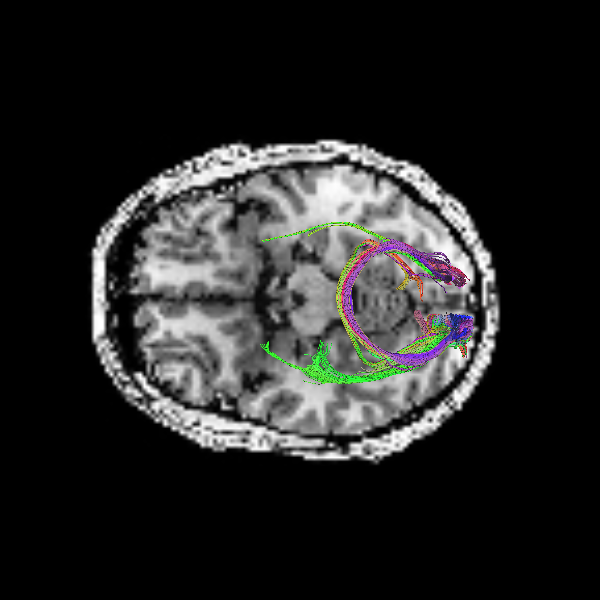

In [49]:
display(Image(filename='det-track.png'))

Finally, these tracks are saved into a standard file format, the '.trk', or [Trackvis](http://www.trackvis.org/) format. This file can then also be used in other applications, such as Trackviz, and many others.

In [50]:
save_trk("det-track.trk", streamlines, affine, data.shape[:3])